In [1]:
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.style.use('seaborn-white')
sns.set_context("talk")

rcParams['figure.figsize'] = 12, 5 
rcParams['font.family'] = 'sans-serif'

font_title = {
    'size': 18, 
    'weight': 600, 
    'name': 'Georgia'
}

font_axes = {
    'size': 16, 
    'weight': 500, 
    'name': 'Georgia'
}

font_text = {
    'size': 14, 
    'weight': 300, 
    'name': 'Verdana'
}

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.chdir("..")
print(os.getcwd())

/Users/dkhosla/temp/ds-docker-walkthru-titanic


In [3]:
from src import URL_TITANIC
from src.obtain import get_raw_data
from src.scrub import scrub_raw_data

In [4]:
if not os.path.exists('data/04-processed/titanic.csv'):
    print("Importing and scrubbing raw data.")
    df_raw = get_raw_data(url=URL_TITANIC)
    df = scrub_raw_data(df_raw)
else:
    print("Retrieving cleaned data from backup.")
    df = pd.read_csv('data/04-processed/titanic.csv')

Retrieving cleaned data from backup.


## Explore

- Univariate (distributions)
- Bivariate (correlations)
- By-group analysis
- Feature Engineering
- Feature Selection

In [5]:
y = df['survived'].copy()

print("Average Survival Rate: {}%".format(y.mean().round(3) * 100))

Average Survival Rate: 38.2%


''

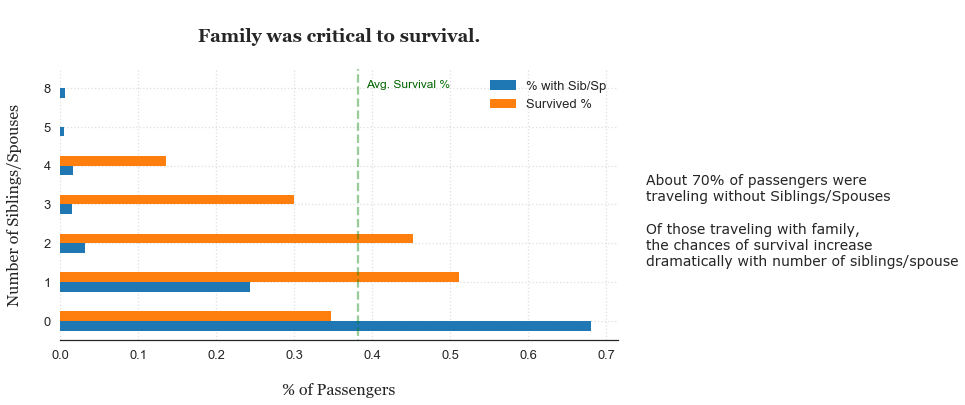

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

pd.DataFrame({
    'Survived %': df.groupby('sibsp').apply(lambda g: g.loc[:, 'survived'].mean()),
    '% with Sib/Sp': df['sibsp'].value_counts(normalize=True)
}).plot.barh(ax=ax)

ax.set_title("\nFamily was critical to survival.\n", fontdict=font_title);
ax.set_xlabel("\n% of Passengers", fontdict=font_axes)
ax.set_ylabel("Number of Siblings/Spouses\n", fontdict=font_axes)

ax.vlines(y.mean(), -1, 9, color='green', linestyle='dashed', alpha=0.4)
ax.annotate(s="Avg. Survival %", xy=(y.mean() + 0.01 , 6), color='darkgreen', fontsize=12)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.75, 1, 
        """About 70% of passengers were \ntraveling without Siblings/Spouses 
        \nOf those traveling with family, \nthe chances of survival increase \ndramatically with number of siblings/spouse
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/01-survival-by-sibsp.png", bbox_inches='tight', pad_inches=0.5)
;

''

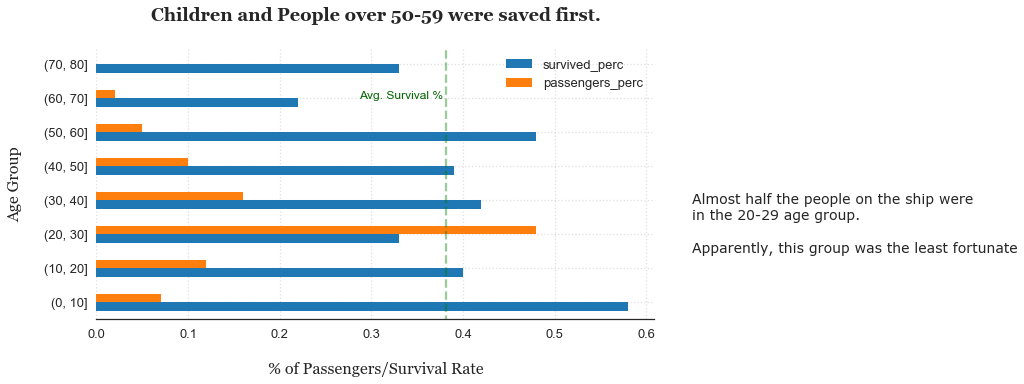

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

(pd.DataFrame({
    'age_group': pd.cut(df['age'], bins=range(0, 81, 10)),
    'survived': y
})
 .groupby('age_group')
 .apply(lambda g: (g.loc[:, 'survived'].mean(), g.shape[0]/float(df.shape[0])))
 .reset_index()
 .assign(survived_perc = lambda fr: fr.loc[:, 0].map(lambda i: i[0]),
         passengers_perc = lambda fr: fr.loc[:, 0].map(lambda i: i[1]))
 .drop([0], axis=1)
 .set_index('age_group')
 .round(2)
 .plot.barh(ax=ax)
)

ax.set_title("Children and People over 50-59 were saved first.\n", fontdict=font_title);
ax.set_xlabel("\n% of Passengers/Survival Rate", fontdict=font_axes)
ax.set_ylabel("Age Group\n", fontdict=font_axes)

ax.vlines(y.mean(), -1, 9, color='green', linestyle='dashed', alpha=0.4)
ax.annotate(s="Avg. Survival %", xy=(y.mean() - 0.095 , 6), color='darkgreen', fontsize=12)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.65, 1, 
        """Almost half the people on the ship were \nin the 20-29 age group.
        \nApparently, this group was the least fortunate
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/01-survival-by-age-group.png", bbox_inches='tight', pad_inches=0.5)
;

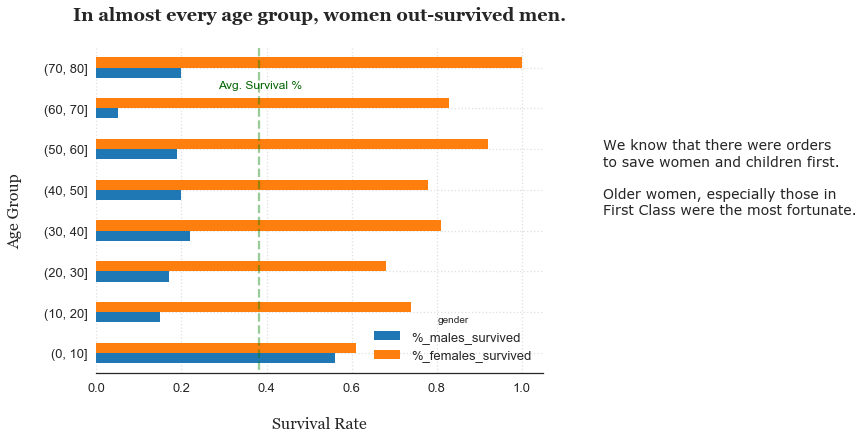

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

(pd.pivot_table(
    data=pd.DataFrame({
        'age_group': pd.cut(df['age'], bins=range(0, 81, 10)),
        'survived': y,
        'gender': df['gender']
    }), 
    index='age_group', 
    columns='gender', 
    values='survived', 
    aggfunc='mean'
).round(2).rename(columns={
    0: '%_males_survived',
    1: '%_females_survived'
})
).plot.barh(ax=ax)


ax.set_title("In almost every age group, women out-survived men.\n", fontdict=font_title);
ax.set_xlabel("\nSurvival Rate", fontdict=font_axes)
ax.set_ylabel("Age Group\n", fontdict=font_axes)

ax.vlines(y.mean(), -1, 9, color='green', linestyle='dashed', alpha=0.4)
ax.annotate(s="Avg. Survival %", xy=(y.mean() - 0.095 , 6.5), color='darkgreen', fontsize=12)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(1.1, 3, 
        """
        We know that there were orders
        to save women and children first.
        
        Older women, especially those in
        First Class were the most fortunate.
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/01-survival-by-age-group-and-gender.png", bbox_inches='tight', pad_inches=0.5);

---

# Feature Selection

In [10]:
X = df.copy().drop(['survived'], axis=1)
y = df['survived'].copy()

from src.explore import find_important_variables

important_vars = find_important_variables(X=X, y=y)

There are 15 variables.
There are 0 Zero Variance Predictors. Ignoring these...
There are 0 Variables with over 90% missing data. Ignoring these...
Now there are 15 variables.
Scaling Data (filling missings with Zeros.)...
Finished.
Calculating % difference in means...
Finished.
Calculating f-scores and p-values...
Fitting default regression-based models and calculating standardized coefficients...
Fitting default tree-based models and finding feature importances...
Putting them all together...
9 variables have a p-value under 0.05
Returning variable importance ranks in a DataFrame...

Note that a higher Average Rank of Variables is better.

Here are the first few variables...
gender        12.2
fare          11.0
embarked_C     9.0
pclass_1       8.8
parch          8.5
Name: avg_rank, dtype: float64


''

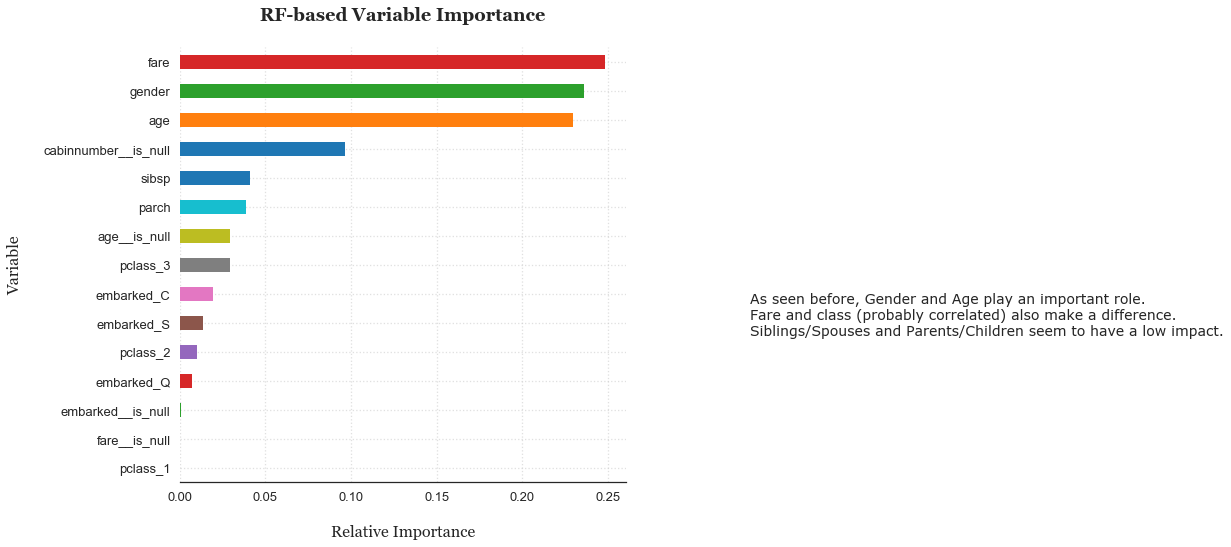

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

important_vars.loc[:, 'rafo_imps'].sort_values().plot.barh(ax=ax)

ax.set_title("RF-based Variable Importance\n", fontdict=font_title);
ax.set_xlabel("\nRelative Importance", fontdict=font_axes)
ax.set_ylabel("Variable\n", fontdict=font_axes)

ax.grid(True, linestyle=":", alpha=0.6)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.31, 4, 
        """
        As seen before, Gender and Age play an important role.
        Fare and class (probably correlated) also make a difference.
        Siblings/Spouses and Parents/Children seem to have a low impact.
        """, 
        fontdict=font_text)

plt.savefig("reports/figures/04-variable-importance.png", bbox_inches='tight', pad_inches=0.5)
;